In [28]:
info_url = e.get_info_url(response="csv")
e_info = pd.read_csv(info_url)

start = e_info.loc[e_info["Attribute Name"] == "time_coverage_start", "Value"].item()
end   = e_info.loc[e_info["Attribute Name"] == "time_coverage_end", "Value"].item()

print("Time coverage:", start, "to", end)


Time coverage: 2020-01-01T00:00:00Z to 2020-01-01T00:00:00Z


In [29]:
e.constraints["time>="] = "2020-01-01T00:00:00Z"
e.constraints["time<="] = "2020-01-01T00:00:00Z"


In [30]:
from erddapy import ERDDAP
import pandas as pd

# Connect
e = ERDDAP(
    server="https://erddap.emodnet.eu/erddap",
    protocol="griddap"
)

e.dataset_id = "GLODAPv2_2016b_CMEMS"
e.griddap_initialize()

# Inspect coverage
info_url = e.get_info_url(response="csv")
e_info = pd.read_csv(info_url)

start = e_info.loc[e_info["Attribute Name"] == "time_coverage_start", "Value"].item()
end   = e_info.loc[e_info["Attribute Name"] == "time_coverage_end", "Value"].item()
minlat = float(e_info.loc[e_info["Attribute Name"] == "geospatial_lat_min", "Value"].item())
maxlat = float(e_info.loc[e_info["Attribute Name"] == "geospatial_lat_max", "Value"].item())
minlon = float(e_info.loc[e_info["Attribute Name"] == "geospatial_lon_min", "Value"].item())
maxlon = float(e_info.loc[e_info["Attribute Name"] == "geospatial_lon_max", "Value"].item())

print("Dataset covers:", start, "to", end)
print(f"Latitude range: {minlat} to {maxlat}")
print(f"Longitude range: {minlon} to {maxlon}")

# Variables
e.variables = ["TCO2", "TAlk", "pHts25p0"]

# Use valid coverage for constraints
e.constraints["time>="] = start
e.constraints["time<="] = end
e.constraints["latitude>="] = minlat
e.constraints["latitude<="] = maxlat
e.constraints["longitude>="] = minlon
e.constraints["longitude<="] = maxlon

# Fetch
ds = e.to_xarray()
print(ds)
print(ds["TCO2"].isel(time=0).values)   # first slice


Dataset covers: 2020-01-01T00:00:00Z to 2020-01-01T00:00:00Z
Latitude range: -89.5 to 89.5
Longitude range: 20.5 to 379.5
<xarray.Dataset> Size: 51MB
Dimensions:    (time: 1, depth: 33, latitude: 180, longitude: 360)
Coordinates:
  * time       (time) datetime64[ns] 8B 2020-01-01
  * depth      (depth) float64 264B 0.0 10.0 20.0 30.0 ... 4.5e+03 5e+03 5.5e+03
  * latitude   (latitude) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * longitude  (longitude) float64 3kB 20.5 21.5 22.5 23.5 ... 377.5 378.5 379.5
Data variables:
    TCO2       (time, depth, latitude, longitude) float64 17MB ...
    TAlk       (time, depth, latitude, longitude) float64 17MB ...
    pHts25p0   (time, depth, latitude, longitude) float64 17MB ...
Attributes: (12/54)
    area:                          Global Ocean
    author:                        GLODAP and Copernicus data provider
    cdm_data_type:                 Grid
    citation:                      These data were collected and made freely ...

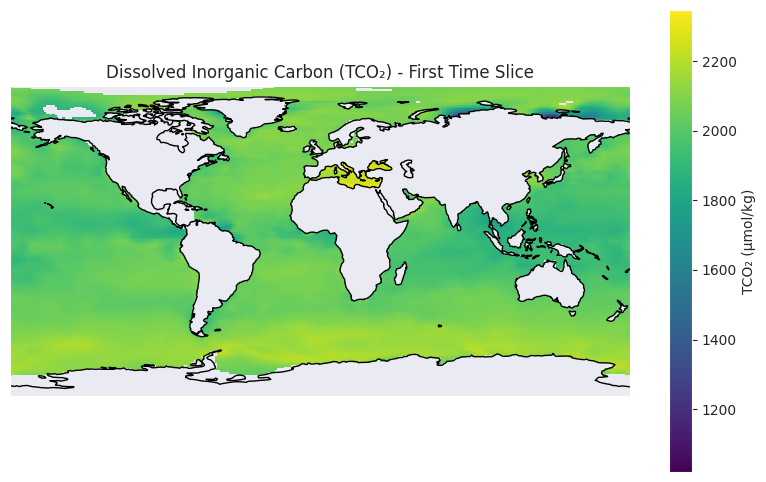

In [31]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Select first time slice, surface depth (depth=0)
tco2_slice = ds["TCO2"].isel(time=0, depth=0)

# Plot
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
tco2_slice.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="viridis",
    cbar_kwargs={"label": "TCO₂ (µmol/kg)"}
)
ax.coastlines()
ax.set_title("Dissolved Inorganic Carbon (TCO₂) - First Time Slice")
plt.savefig("TCO2_First_Slice.png", dpi=300, bbox_inches="tight")
plt.show()


## Visualization of how much dissolved inorganic carbon (DIC) is present in different parts of the global surface ocean, at one time snapshot.

High concentrations (yellow/green) → typically in the North Atlantic and some equatorial upwelling zones, where deep carbon-rich water mixes upward.

Lower concentrations (purple/blue) → in warmer surface waters, especially subtropical gyres, where CO₂ is outgassed to the atmosphere.

### Carbon data becomes a parallel data source, aligned in time & space with your other environmental variables.
### Once harmonized, it feeds into both analysis and visualization stages.

In [39]:
import pandas as pd

# --- Step 1: Load JeDI (jellyfish) dataset ---
df_jelly = pd.read_csv("../data/JeDI.csv")

print("Raw jellyfish data shape:", df_jelly.shape)
print(df_jelly[["lat", "lon", "presence_absence"]].head())


# --- Step 2: Bin jellyfish occurrences ---
def bin_grid(df, cellsize=1):
    """Bins jellyfish presence records into a lat/lon grid."""
    df = df.copy()
    # round to nearest grid cell
    # In Step 2: use cellsize argument properly
    df["lat_bin"] = (df["lat"] / cellsize).round().astype(int) * cellsize
    df["lon_bin"] = (df["lon"] / cellsize).round().astype(int) * cellsize

    # count only PRESENCE records
    df = df[df["presence_absence"].str.lower() == "present"]
    return (
        df.groupby(["lat_bin", "lon_bin"])
        .size()
        .reset_index(name="jelly_count")
    )


grid_jelly = bin_grid(df_jelly)
print("Binned jellyfish data shape:", grid_jelly.shape)
print(grid_jelly.head())

# --- Step 3: Fetch Carbon dataset directly from ERDDAP ---
df_carbon = ds["TCO2"].to_dataframe().reset_index()

# Harmonize bins
df_carbon["lat_bin"] = df_carbon["latitude"].round().astype(int)
df_carbon["lon_bin"] = df_carbon["longitude"].round().astype(int)
df_carbon = df_carbon.rename(columns={"TCO2": "carbon"}).dropna(subset=["carbon"])

print("Carbon data shape:", df_carbon.shape)
print(df_carbon.head())


# --- Step 4: Merge datasets ---
merged = pd.merge(
    grid_jelly,
    df_carbon[["lat_bin", "lon_bin", "carbon"]],
    on=["lat_bin", "lon_bin"],
    how="inner"
)

print("Merged dataset shape:", merged.shape)
print(merged.head())

# --- Step 5: Correlation ---
pearson_corr = merged[["jelly_count", "carbon"]].corr(method="pearson")
print("\nPearson correlation:")
print(pearson_corr)

spearman_corr = merged[["jelly_count", "carbon"]].corr(method="spearman")
print("\nSpearman correlation:")
print(spearman_corr)


/tmp/ipykernel_12323/2761117340.py:4: DtypeWarning: Columns (7,8,22,23,25,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df_jelly = pd.read_csv("JeDI.csv")


Raw jellyfish data shape: (429462, 37)
         lat        lon presence_absence
0  44.924375  13.156222           absent
1  44.924375  13.156222           absent
2  44.924375  13.156222           absent
3  44.924375  13.156222           absent
4  44.924375  13.156222          present
Binned jellyfish data shape: (6446, 3)
   lat_bin  lon_bin  jelly_count
0      -78     -173            1
1      -78     -166            1
2      -78     -165            1
3      -78     -164            1
4      -78      166            1
Carbon data shape: (1103356, 7)
           time  depth  latitude  longitude       carbon  lat_bin  lon_bin
4464 2020-01-01    0.0     -77.5      164.5  2010.963379      -78      164
4465 2020-01-01    0.0     -77.5      165.5  2040.406982      -78      166
4477 2020-01-01    0.0     -77.5      177.5  2112.958496      -78      178
4478 2020-01-01    0.0     -77.5      178.5  2128.190918      -78      178
4479 2020-01-01    0.0     -77.5      179.5  2142.515869      -78      

### Pearson correlation (r = -0.0209)
→ Very weak negative linear relationship between jellyfish abundance and carbon (TCO₂).
Statistically almost no linear correlation.

Spearman correlation (ρ = 0.0616)
→ Very weak positive rank-based relationship.
Suggests that, when you order grid cells by jellyfish counts and carbon values, there’s a tiny positive association — but again, basically negligible.

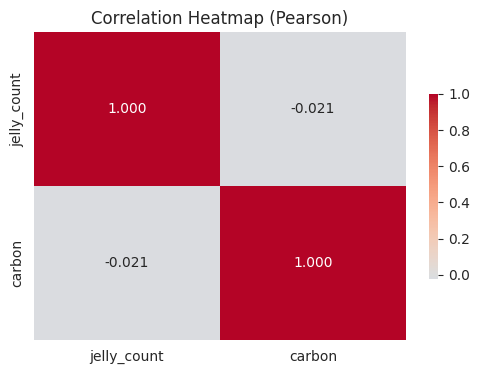

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Compute correlation matrix ---
corr_matrix = merged[["jelly_count", "carbon"]].corr(method="pearson")

# --- Plot heatmap ---
plt.figure(figsize=(6,4))
sns.heatmap(
    corr_matrix,
    annot=True, fmt=".3f", cmap="coolwarm", center=0,
    cbar_kws={"shrink": 0.6}
)
plt.title("Correlation Heatmap (Pearson)")
plt.show()
